## Imports

In [1]:
import os
import sys
##----Insert path to LaneGCN here-----#
sys.path.insert(0, "/home/p6bhatta/SSL-Lanes/LaneGCN")
root_path = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(root_path)

import argparse
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import ArgoTestDataset
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.utils.centerline_utils import (
    get_nt_distance,
    remove_overlapping_lane_seq,)
from argoverse.utils.mpl_plotting_utils import visualize_centerline

from utils import Logger, load_pretrain

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import copy
from shapely.ops import nearest_points

## Requirements for the game-theoretic solver

1. Provide past 2 sec history of every vehicle
2. Provide 3 sec predictions of every vehicle
3. Provide lane centerline of every vehicle
4. Provide say a 1xn matrix of vehicle of interest and its intersections in the 3 sec future with other vehicles
5. Along path distance for vehicles whose futures intersect

## Utils

In [2]:
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import cascaded_union

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.utils.centerline_utils import (
    get_nt_distance,
    remove_overlapping_lane_seq,
)
from argoverse.utils.mpl_plotting_utils import visualize_centerline
from baseline_config import (
    _MANHATTAN_THRESHOLD,
    _DFS_THRESHOLD_FRONT_SCALE,
    _DFS_THRESHOLD_BACK_SCALE,
    _MAX_SEARCH_RADIUS_CENTERLINES,
    _MAX_CENTERLINE_CANDIDATES_TEST,
)


class MapFeaturesUtils:
    """Utils for computation of map-based features."""
    def __init__(self):
        """Initialize class."""
        self._MANHATTAN_THRESHOLD = _MANHATTAN_THRESHOLD
        self._DFS_THRESHOLD_FRONT_SCALE = _DFS_THRESHOLD_FRONT_SCALE
        self._DFS_THRESHOLD_BACK_SCALE = _DFS_THRESHOLD_BACK_SCALE
        self._MAX_SEARCH_RADIUS_CENTERLINES = _MAX_SEARCH_RADIUS_CENTERLINES
        self._MAX_CENTERLINE_CANDIDATES_TEST = _MAX_CENTERLINE_CANDIDATES_TEST

    def get_point_in_polygon_score(self, lane_seq: List[int],
                                   xy_seq: np.ndarray, city_name: str,
                                   avm: ArgoverseMap) -> int:
        """Get the number of coordinates that lie insde the lane seq polygon.
        Args:
            lane_seq: Sequence of lane ids
            xy_seq: Trajectory coordinates
            city_name: City name (PITT/MIA)
            avm: Argoverse map_api instance
        Returns:
            point_in_polygon_score: Number of coordinates in the trajectory that lie within the lane sequence
        """
        lane_seq_polygon = cascaded_union([
            Polygon(avm.get_lane_segment_polygon(lane, city_name)).buffer(0)
            for lane in lane_seq
        ])
        point_in_polygon_score = 0
        for xy in xy_seq:
            point_in_polygon_score += lane_seq_polygon.contains(Point(xy))
        return point_in_polygon_score

    def sort_lanes_based_on_point_in_polygon_score(
            self,
            lane_seqs: List[List[int]],
            xy_seq: np.ndarray,
            city_name: str,
            avm: ArgoverseMap,
    ) -> List[List[int]]:
        """Filter lane_seqs based on the number of coordinates inside the bounding polygon of lanes.
        Args:
            lane_seqs: Sequence of lane sequences
            xy_seq: Trajectory coordinates
            city_name: City name (PITT/MIA)
            avm: Argoverse map_api instance
        Returns:
            sorted_lane_seqs: Sequences of lane sequences sorted based on the point_in_polygon score
        """
        point_in_polygon_scores = []
        for lane_seq in lane_seqs:
            point_in_polygon_scores.append(
                self.get_point_in_polygon_score(lane_seq, xy_seq, city_name,
                                                avm))
        randomized_tiebreaker = np.random.random(len(point_in_polygon_scores))
        sorted_point_in_polygon_scores_idx = np.lexsort(
            (randomized_tiebreaker, np.array(point_in_polygon_scores)))[::-1]
        sorted_lane_seqs = [
            lane_seqs[i] for i in sorted_point_in_polygon_scores_idx
        ]
        sorted_scores = [
            point_in_polygon_scores[i]
            for i in sorted_point_in_polygon_scores_idx
        ]
        return sorted_lane_seqs, sorted_scores

    def get_heuristic_centerlines_for_test_set(
            self,
            lane_seqs: List[List[int]],
            xy_seq: np.ndarray,
            city_name: str,
            avm: ArgoverseMap,
            max_candidates: int,
            scores: List[int],
    ) -> List[np.ndarray]:
        """Sort based on distance along centerline and return the centerlines.
        
        Args:
            lane_seqs: Sequence of lane sequences
            xy_seq: Trajectory coordinates
            city_name: City name (PITT/MIA)
            avm: Argoverse map_api instance
            max_candidates: Maximum number of centerlines to return
        Return:
            sorted_candidate_centerlines: Centerlines in the order of their score 
        """
        aligned_centerlines = []
        diverse_centerlines = []
        diverse_scores = []
        num_candidates = 0

        # Get first half as aligned centerlines
        aligned_cl_count = 0
        for i in range(len(lane_seqs)):
            lane_seq = lane_seqs[i]
            score = scores[i]
            diverse = True
            centerline = avm.get_cl_from_lane_seq([lane_seq], city_name)[0]
            if aligned_cl_count < int(max_candidates / 2):
                start_dist = LineString(centerline).project(Point(xy_seq[0]))
                end_dist = LineString(centerline).project(Point(xy_seq[-1]))
                if end_dist > start_dist:
                    aligned_cl_count += 1
                    aligned_centerlines.append(centerline)
                    diverse = False
            if diverse:
                diverse_centerlines.append(centerline)
                diverse_scores.append(score)

        num_diverse_centerlines = min(len(diverse_centerlines),
                                      max_candidates - aligned_cl_count)
        test_centerlines = aligned_centerlines
        if num_diverse_centerlines > 0:
            probabilities = ([
                float(score + 1) / (sum(diverse_scores) + len(diverse_scores))
                for score in diverse_scores
            ] if sum(diverse_scores) > 0 else [1.0 / len(diverse_scores)] *
                             len(diverse_scores))
            diverse_centerlines_idx = np.random.choice(
                range(len(probabilities)),
                num_diverse_centerlines,
                replace=False,
                p=probabilities,
            )
            diverse_centerlines = [
                diverse_centerlines[i] for i in diverse_centerlines_idx
            ]
            test_centerlines += diverse_centerlines

        return test_centerlines

    def get_candidate_centerlines_for_trajectory(
            self,
            xy: np.ndarray,
            city_name: str,
            avm: ArgoverseMap,
            viz: bool = False,
            max_search_radius: float = 50.0,
            seq_len: int = 50,
            max_candidates: int = 10,
            mode: str = "test",
    ) -> List[np.ndarray]:
        """Get centerline candidates upto a threshold.
        Algorithm:
        1. Take the lanes in the bubble of last observed coordinate
        2. Extend before and after considering all possible candidates
        3. Get centerlines based on point in polygon score.
        Args:
            xy: Trajectory coordinates, 
            city_name: City name, 
            avm: Argoverse map_api instance, 
            viz: Visualize candidate centerlines, 
            max_search_radius: Max search radius for finding nearby lanes in meters,
            seq_len: Sequence length, 
            max_candidates: Maximum number of centerlines to return, 
            mode: train/val/test mode
        Returns:
            candidate_centerlines: List of candidate centerlines
        """
        # Get all lane candidates within a bubble
        curr_lane_candidates = avm.get_lane_ids_in_xy_bbox(
            xy[-1, 0], xy[-1, 1], city_name, self._MANHATTAN_THRESHOLD)

        # Keep expanding the bubble until at least 1 lane is found
        while (len(curr_lane_candidates) < 1
               and self._MANHATTAN_THRESHOLD < max_search_radius):
            self._MANHATTAN_THRESHOLD *= 2
            curr_lane_candidates = avm.get_lane_ids_in_xy_bbox(
                xy[-1, 0], xy[-1, 1], city_name, self._MANHATTAN_THRESHOLD)

        assert len(curr_lane_candidates) > 0, "No nearby lanes found!!"

        # Set dfs threshold
        traj_len = xy.shape[0]

        # Assuming a speed of 50 mps, set threshold for traversing in the front and back
        dfs_threshold_front = (self._DFS_THRESHOLD_FRONT_SCALE *
                               (seq_len + 1 - traj_len) / 10)
        dfs_threshold_back = self._DFS_THRESHOLD_BACK_SCALE * (traj_len +
                                                               1) / 10

        # DFS to get all successor and predecessor candidates
        obs_pred_lanes: List[Sequence[int]] = []
        for lane in curr_lane_candidates:
            candidates_future = avm.dfs(lane, city_name, 0,
                                        dfs_threshold_front)
            candidates_past = avm.dfs(lane, city_name, 0, dfs_threshold_back,
                                      True)

            # Merge past and future
            for past_lane_seq in candidates_past:
                for future_lane_seq in candidates_future:
                    assert (
                        past_lane_seq[-1] == future_lane_seq[0]
                    ), "Incorrect DFS for candidate lanes past and future"
                    obs_pred_lanes.append(past_lane_seq + future_lane_seq[1:])

        # Removing overlapping lanes
        obs_pred_lanes = remove_overlapping_lane_seq(obs_pred_lanes)

        # Sort lanes based on point in polygon score
        obs_pred_lanes, scores = self.sort_lanes_based_on_point_in_polygon_score(
            obs_pred_lanes, xy, city_name, avm)

        # If the best centerline is not along the direction of travel, re-sort
        if mode == "test":
            candidate_centerlines = self.get_heuristic_centerlines_for_test_set(
                obs_pred_lanes, xy, city_name, avm, max_candidates, scores)
        else:
            candidate_centerlines = avm.get_cl_from_lane_seq(
                [obs_pred_lanes[0]], city_name)

        if viz:
            plt.figure(0, figsize=(8, 7))
            for centerline_coords in candidate_centerlines:
                visualize_centerline(centerline_coords)
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "-",
                color="#d33e4c",
                alpha=1,
                linewidth=3,
                zorder=15,
            )

            final_x = xy[-1, 0]
            final_y = xy[-1, 1]

            plt.plot(
                final_x,
                final_y,
                "o",
                color="#d33e4c",
                alpha=1,
                markersize=10,
                zorder=15,
            )
            plt.xlabel("Map X")
            plt.ylabel("Map Y")
            plt.axis("off")
            plt.title(f"Number of candidates = {len(candidate_centerlines)}")
            plt.show()

        return candidate_centerlines

    def compute_map_features(
            self,
            agent_track: np.ndarray,
            obs_len: int,
            seq_len: int,
            raw_data_format: Dict[str, int],
            mode: str,
    ) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Compute map based features for the given sequence.
        If the mode is test, oracle_nt_dist will be empty, candidate_nt_dist will be populated.
        If the mode is train/val, oracle_nt_dist will be populated, candidate_nt_dist will be empty.
        Args:
            agent_track : Data for the agent track
            obs_len : Length of observed trajectory
            seq_len : Length of the sequence
            raw_data_format : Format of the sequence
            mode: train/val/test mode
            
        Returns:
            oracle_nt_dist (numpy array): normal and tangential distances for oracle centerline
                map_feature_helpers (dict): Dictionary containing helpers for map features
        """
        # Get observed 2 secs of the agent
        agent_xy = agent_track[:, [raw_data_format["X"], raw_data_format["Y"]
                                   ]].astype("float")
        agent_track_obs = agent_track[:obs_len]
        agent_xy_obs = agent_track_obs[:, [
            raw_data_format["X"], raw_data_format["Y"]
        ]].astype("float")

        # Get API for Argo Dataset map
        avm = ArgoverseMap()

        city_name = agent_track[0, raw_data_format["CITY_NAME"]]

        # Get candidate centerlines using observed trajectory
        if mode == "test":
            oracle_centerline = np.full((seq_len, 2), None)
            oracle_nt_dist = np.full((seq_len, 2), None)
            candidate_centerlines = self.get_candidate_centerlines_for_trajectory(
                agent_xy_obs,
                city_name,
                avm,
                viz=False,
                max_search_radius=self._MAX_SEARCH_RADIUS_CENTERLINES,
                seq_len=seq_len,
                max_candidates=self._MAX_CENTERLINE_CANDIDATES_TEST,
            )

            # Get nt distance for the entire trajectory using candidate centerlines
            candidate_nt_distances = []
            for candidate_centerline in candidate_centerlines:
                candidate_nt_distance = np.full((seq_len, 2), None)
                candidate_nt_distance[:obs_len] = get_nt_distance(
                    agent_xy_obs, candidate_centerline)
                candidate_nt_distances.append(candidate_nt_distance)

        else:
            oracle_centerline = self.get_candidate_centerlines_for_trajectory(
                agent_xy,
                city_name,
                avm,
                viz=False,
                max_search_radius=self._MAX_SEARCH_RADIUS_CENTERLINES,
                seq_len=seq_len,
                mode=mode,
            )[0]
            candidate_centerlines = [np.full((seq_len, 2), None)]
            candidate_nt_distances = [np.full((seq_len, 2), None)]

            # Get NT distance for oracle centerline
            oracle_nt_dist = get_nt_distance(agent_xy,
                                             oracle_centerline,
                                             viz=False)

        map_feature_helpers = {
            "ORACLE_CENTERLINE": oracle_centerline,
            "CANDIDATE_CENTERLINES": candidate_centerlines,
            "CANDIDATE_NT_DISTANCES": candidate_nt_distances,
        }

        return oracle_nt_dist, map_feature_helpers

## Vis Utils

In [3]:
from collections import defaultdict
from typing import Dict, List, Optional

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as interp

from argoverse.map_representation.map_api import ArgoverseMap

_ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}


def interpolate_polyline(polyline: np.ndarray, num_points: int) -> np.ndarray:
    duplicates = []
    for i in range(1, len(polyline)):
        if np.allclose(polyline[i], polyline[i - 1]):
            duplicates.append(i)
    if polyline.shape[0] - len(duplicates) < 4:
        return polyline
    if duplicates:
        polyline = np.delete(polyline, duplicates, axis=0)
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.column_stack(interp.splev(u, tck))

def viz_sequence_mod(
    df: pd.DataFrame,
    lane_centerlines: Optional[List[np.ndarray]] = None,
    show: bool = True,
    smoothen: bool = False,
) -> None:

    # Seq data
    city_name = df["CITY_NAME"].values[0]

    if lane_centerlines is None:
        # Get API for Argo Dataset map
        avm = ArgoverseMap()
        seq_lane_props = avm.city_lane_centerlines_dict[city_name]

    plt.figure(0, figsize=(8, 7))

    x_min = min(df["X"])
    x_max = max(df["X"])
    y_min = min(df["Y"])
    y_max = max(df["Y"])

    if lane_centerlines is None:

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        lane_centerlines = []
        # Get lane centerlines which lie within the range of trajectories
        for lane_id, lane_props in seq_lane_props.items():

            lane_cl = lane_props.centerline

            if (
                np.min(lane_cl[:, 0]) < x_max
                and np.min(lane_cl[:, 1]) < y_max
                and np.max(lane_cl[:, 0]) > x_min
                and np.max(lane_cl[:, 1]) > y_min
            ):
                lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(
            lane_cl[:, 0],
            lane_cl[:, 1],
            "--",
            color="grey",
            alpha=1,
            linewidth=1,
            zorder=0,
        )
    frames = df.groupby("TRACK_ID")

    plt.xlabel("Map X")
    plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#d3e8ef", "AV": "#007672"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for ii, (group_name, group_data) in enumerate(frames):
        object_type = group_data["OBJECT_TYPE"].values[0]
    
        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )
        
        #------Add------------
        if str(group_name) in vis_list:
            plt.plot(
            cor_x,
            cor_y,
            "-",
            color='purple',
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=10,)
            
            final_x = cor_x[-1]
            final_y = cor_y[-1]
            
            plt.plot(
            final_x,
            final_y,
            'o',
            color='purple',
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=7,
            zorder=10,
            )
        #------Add------------


        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D(
        [],
        [],
        color="green",
        marker="o",
        linestyle="None",
        markersize=7,
        label="Others",
    )
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    plt.axis("off")
    if show:
        plt.show()

## Arguments for model

In [4]:
print("Argoverse Motion Forecasting Interface in Pytorch")
args_model = 'lanegcn'
eval = True
split = 'val'
##----Insert path to LaneGCN checkpoint here-----#
weight = '/home/p6bhatta/SSL-Lanes/LaneGCN/results/lanegcn/ckpt/36.000.ckpt'

Argoverse Motion Forecasting Interface in Pytorch


## Load Model

In [5]:
model = import_module(args_model)
config, _, collate_fn, net, loss, post_process, opt = model.get_model()
# load pretrain model
ckpt_path = weight
if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()

Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

## Dataloader 

In [6]:
dataset = ArgoTestDataset(split, config, train=False)
data_loader = DataLoader(
        dataset,
        batch_size=config["val_batch_size"],
        num_workers=config["val_workers"],
        collate_fn=collate_fn,
        shuffle=True,
        pin_memory=True,
    )

## Begin Inference

In [7]:
preds = {}
gts = {}
cities = {}

data = next(iter(data_loader))  
print("--------Here is the sample being considered:---------")
print("Sample id: ", data['argo_id'][0])
print("City: ", data['city'][0])

--------Here is the sample being considered:---------
Sample id:  15502
City:  PIT


## Visualize chosen data sample

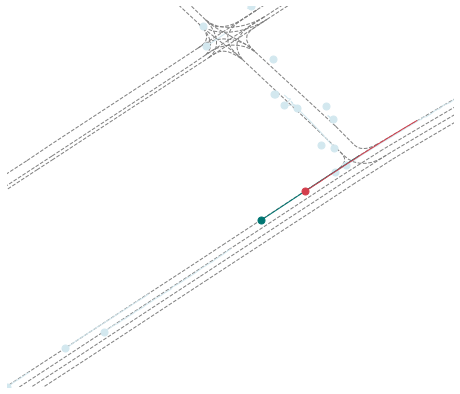

In [8]:
from argoverse.visualization.visualize_sequences import viz_sequence

## map
am = ArgoverseMap()

##set root_dir to the correct path to your dataset folder
root_dir = '../LaneGCN/dataset/val/data/'
afl = ArgoverseForecastingLoader(root_dir)
afl.seq_list = sorted(afl.seq_list)

seq_path = os.path.join(root_dir, str(data['argo_id'][0])+'.csv')
viz_sequence(afl.get(seq_path).seq_df, show=True)

## 1. Get the Past for 2 secs of every trajectory in the data sample in the original coordinate system 
Note: the data in the dict is pre-processed so that the agent of interest is at the origin.

Also, in the seq_df not all agents are considered at the end for prediction.

In [9]:
## Input: seq_df
## Output: The data of past 20secs of valid trajectories to be 
## considered for prediction in the original coordinate system (save_trajs)

save_trajs = []

seq_path = os.path.join(root_dir, str(data['argo_id'][0])+'.csv')
city = copy.deepcopy(afl.get(seq_path).city)

"""TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME"""
df = copy.deepcopy(afl.get(seq_path).seq_df)

agt_ts = np.sort(np.unique(df['TIMESTAMP'].values))
mapping = dict()
for i, ts in enumerate(agt_ts):
    mapping[ts] = i

trajs = np.concatenate((
    df.X.to_numpy().reshape(-1, 1),
    df.Y.to_numpy().reshape(-1, 1)), 1)

steps = [mapping[x] for x in df['TIMESTAMP'].values]
steps = np.asarray(steps, np.int64)

objs = df.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
keys = list(objs.keys())

obj_type = [x[1] for x in keys]

agt_idx = obj_type.index('AGENT')
idcs = objs[keys[agt_idx]]

agt_traj = trajs[idcs]
agt_step = steps[idcs]

del keys[agt_idx]
ctx_trajs, ctx_steps = [], []
for key in keys:
    idcs = objs[key]
    ctx_trajs.append(trajs[idcs])
    ctx_steps.append(steps[idcs])

data1 = dict()
data1['city'] = city
data1['trajs'] = [agt_traj] + ctx_trajs
data1['steps'] = [agt_step] + ctx_steps

orig = data1['trajs'][0][19].copy().astype(np.float32)
pre = data1['trajs'][0][18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])

rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]], np.float32)

feats, ctrs, gt_preds, has_preds = [], [], [], []
store_ids = []
for ii, (traj, step) in enumerate(zip(data1['trajs'], data1['steps'])):
    if 19 not in step:
        continue
    gt_pred = np.zeros((30, 2), np.float32)
    has_pred = np.zeros(30, np.bool)
    future_mask = np.logical_and(step >= 20, step < 50)
    post_step = step[future_mask] - 20
    post_traj = traj[future_mask]
    gt_pred[post_step] = post_traj
    has_pred[post_step] = 1

    obs_mask = step < 20
    step = step[obs_mask]
    traj = traj[obs_mask]
    idcs = step.argsort()
    step = step[idcs]
    traj = traj[idcs]

    for i in range(len(step)):
        if step[i] == 19 - (len(step) - 1) + i:
            break
    step = step[i:]
    traj = traj[i:]
    
    feat = np.zeros((20, 3), np.float32)
    feat[step, :2] = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
    feat[step, 2] = 1.0

    x_min, x_max, y_min, y_max = config['pred_range']
    if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
        continue
        
    if ii>0:
        store_ids.append(keys[ii-1])

    ctrs.append(feat[-1, :2].copy())
    feat[1:, :2] -= feat[:-1, :2]
    feat[step[0], :2] = 0
    feats.append(feat)
    gt_preds.append(gt_pred)
    has_preds.append(has_pred)
    
    save_trajs.append(traj)

print("The 2 secs past of every trajectory is saved in save_trajs list...")
print("No of agents: ", len(save_trajs)) 
print("Shape of each agent traj: ", save_trajs[0].shape)

The 2 secs past of every trajectory is saved in save_trajs list...
No of agents:  7
Shape of each agent traj:  (20, 2)


## 2. Get 3 sec predictions for every valid vehicle

In [10]:
data = dict(data)
with torch.no_grad():
    output = net(data)
    #results = [x[0:1].detach().cpu().numpy() for x in output["reg"]]
    results = [x.detach().cpu().numpy() for x in output["reg"]]

for i, (argo_idx, pred_traj) in enumerate(zip(data["argo_id"], results)):
    preds[argo_idx] = pred_traj.squeeze()
    cities[argo_idx] = data["city"][i]
    gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None
    
predictions_traj = results[0]  ## batch==0
print("Shape of predictions: ", predictions_traj.shape)

Shape of predictions:  (7, 6, 30, 2)


## 3. Get a [1xm] matrix of agents whose predicted futures intersect in the next 3 secs with our vehicle of interest

In [26]:
from shapely.geometry import Point, Polygon

multimodal_outs = predictions_traj.shape[1]
agent_pred = predictions_traj[0]
buffer_dist_intersect = 2

intersect_ids = []

for k in range(1, predictions_traj.shape[0]):
    for i in range(multimodal_outs):
        for j in range(multimodal_outs):
            region_polygon = Polygon([p[0], p[1]] for p in predictions_traj[k][i]).buffer(buffer_dist_intersect)
            is_in_region = [region_polygon.intersects(Point(point)) for point in agent_pred[j]]
            if True in is_in_region:
                intersect_ids.append(k)      
intersect_ids = np.unique(np.array(intersect_ids))
print(intersect_ids)

[1 3 5]


In [12]:
vis_list = []
for i in intersect_ids:
    vis_list.append(store_ids[i-1][0])

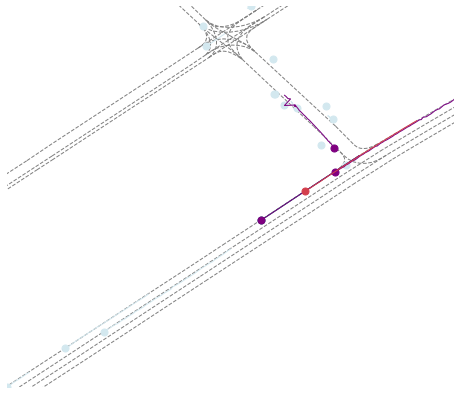

In [13]:
seq_path = os.path.join('../LaneGCN/dataset/val/data/', str(data['argo_id'][0])+'.csv')
viz_sequence_mod(afl.get(seq_path).seq_df, show=True)

## 4 and 5. Get centerlines and along path distance to vehicles whose futures do intersect

/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


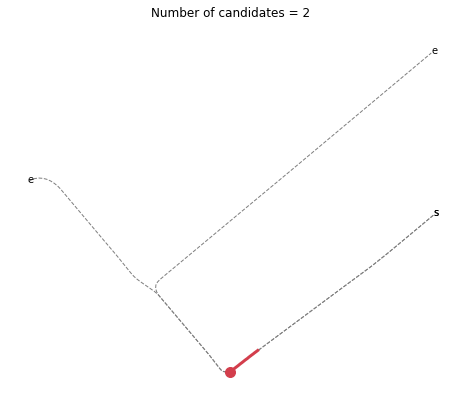

/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


Distance of primary agent from its own centerline:  5.467921641345039e-05


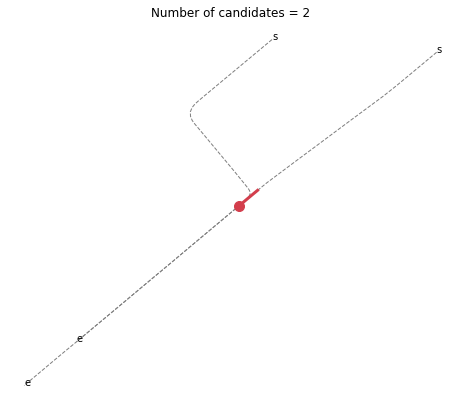

Distance of primary agent from centerlines of agent 1:  13.061936168142044


/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


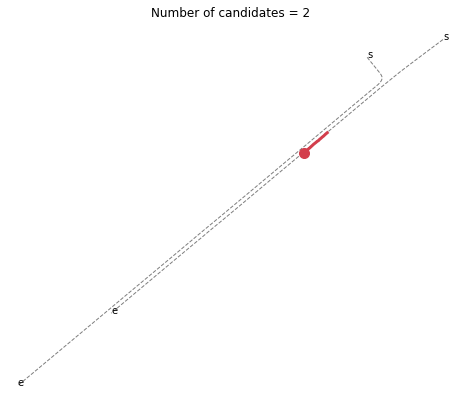

Distance of primary agent from centerlines of agent 2:  81.38972461639989


/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


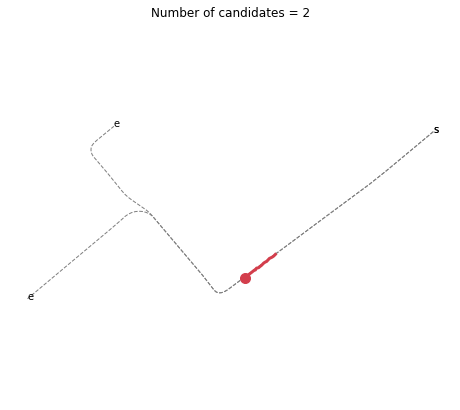

Distance of primary agent from centerlines of agent 3:  14.731345777430505


/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


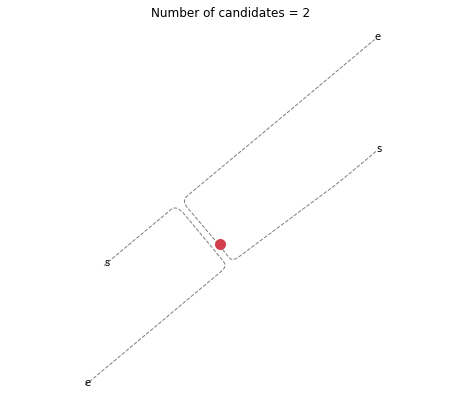

Distance of primary agent from centerlines of agent 4:  15.820796106087105


/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


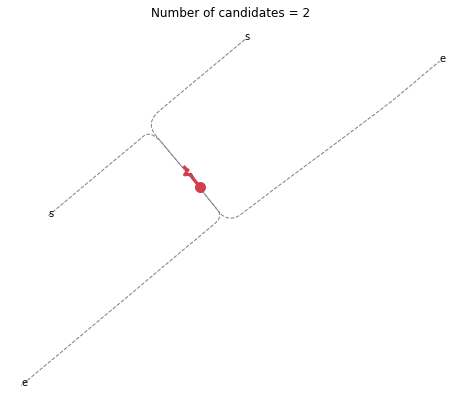

Distance of primary agent from centerlines of agent 5:  20.204877329074264


/tmp/ipykernel_261838/948734587.py:45: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  lane_seq_polygon = cascaded_union([


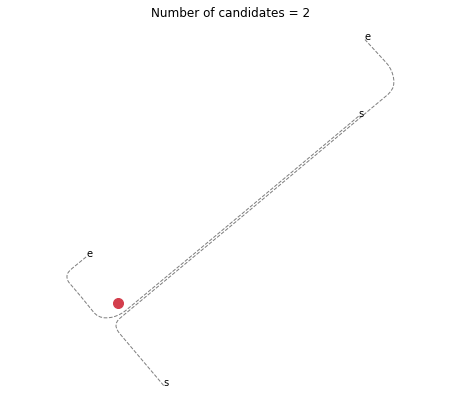

Distance of primary agent from centerlines of agent 6:  6.931120473743323
Along path distance corresponding to intersect ids:  [13.061936168142044, 14.731345777430505, 20.204877329074264]


In [37]:
candidate_centerline_save = []
along_path_dist = []

map_features_utils_instance = MapFeaturesUtils()
candidate_nt_distances = []

orig = data['orig'][0]

for ii, traj in enumerate(save_trajs):
    
    # Get two centerlines per trajectory (function in utils)
    candidate_centerlines = map_features_utils_instance.get_candidate_centerlines_for_trajectory(
            traj,
            data1['city'],
            am,
            viz=True,
            max_candidates=2)
    candidate_centerline_save.append(candidate_centerlines)
   
    # Given the centerline for candidate, find the along path distance between the candidate and the agent
    dist_projections = []
    for candidate_centerline in candidate_centerlines:
        candidate_nt_distance = np.full((20, 2), None)
        candidate_nt_distance = get_nt_distance(np.array([traj[-1]]), candidate_centerline)

        polygon = Polygon(candidate_centerline)
        p2 = nearest_points(polygon, Point(orig))[0]  # chosen agent projected to agent ii's centerline
        p3 = nearest_points(polygon, Point(traj[-1]))[0] # agent ii projected to its own centerline
        
        dist_orig_traj = p2.distance(p3) # distance between the projections
        
        dist_projections.append(dist_orig_traj)
        
    # Out of two 
    dist_min = min(dist_projections)

    candidate_nt_distances.append(candidate_nt_distance)
    if ii == 0:
        print('Distance of primary agent from its own centerline: ', dist_min)
    else:
        print('Distance of primary agent from centerlines of agent %d: '%ii, dist_min)
        
    if ii in intersect_ids:
        along_path_dist.append(dist_min)
        
print("Along path distance corresponding to intersect ids: ", along_path_dist)